In [ ]:
# Google drive link:  https://drive.google.com/drive/folders/1WBqpfST0lEyg3sSPHZPUXeCAX5__XdEa?usp=sharing

In [ ]:
# RAMS dataset link:  https://nlp.jhu.edu/rams/

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

train_data_path = "/content/drive/MyDrive/EE/train.jsonlines"
dev_data_path = "/content/drive/MyDrive/EE/dev.jsonlines"
test_data_path = "/content/drive/MyDrive/EE/test.jsonlines"

# train_data_path = "train.jsonlines"
# dev_data_path = "dev.jsonlines"
# test_data_path = "test.jsonlines"

def load_jsonlines(filepath):
  data = []
  with open(filepath, 'r') as f:
    for line in f:
      data.append(json.loads(line))
  return data

train_data = load_jsonlines(train_data_path)
dev_data = load_jsonlines(dev_data_path)
test_data = load_jsonlines(test_data_path)

print(f"Loaded {len(train_data)} training examples.")
print(f"Loaded {len(dev_data)} development examples.")
print(f"Loaded {len(test_data)} test examples.")
print("Sample training record:", train_data[0])

Mounted at /content/drive
Loaded 7329 training examples.
Loaded 924 development examples.
Loaded 871 test examples.
Sample training record: {'rel_triggers': [], 'gold_rel_links': [], 'doc_key': 'nw_RC000462ebb18ca0b29222d5e557fa31072af8337e3a0910dca8b5b62f', 'ent_spans': [[42, 43, [['evt090arg02victim', 1.0]]], [85, 88, [['evt090arg01killer', 1.0]]], [26, 26, [['evt090arg04place', 1.0]]]], 'language_id': 'eng', 'source_url': 'https://www.washingtonpost.com/news/powerpost/paloma/daily-202/2016/06/17/daily-202-more-republicans-ditch-trump-conclude-he-cannot-win/5763a1e0981b92a22d0f8a36/', 'evt_triggers': [[69, 69, [['life.die.deathcausedbyviolentevents', 1.0]]]], 'split': 'train', 'sentences': [['Transportation', 'officials', 'are', 'urging', 'carpool', 'and', 'teleworking', 'as', 'options', 'to', 'combat', 'an', 'expected', 'flood', 'of', 'drivers', 'on', 'the', 'road', '.'], ['(', 'Paul', 'Duggan', ')'], ['--', 'A', 'Baltimore', 'prosecutor', 'accused', 'a', 'police', 'detective', 'of'

The below is evt_triggers and sentences of one row, 51, 51 indicating the index of trigger token which is smuggled

 {"evt_triggers": [[51, 51, [["movement.transportartifact.hide", 1.0]]]],   "sentences": [["2014", ":", "ISIS", "marches", "into", "Raqqa", "and", "makes", "it", "the", "capital", "of", "the", "caliphate", "."], ["Foto", ":", "Uncredited"], ["The", "two", "Syrian", "women", "who", "we", "shall", "call", "Om", "Omran", "and", "Om", "Mohammad", ",", "which", "are", "not", "their", "real", "names", ",", "were", "willing", "to", "wear", "Expressen", "'s", "hidden", "cameras", ",", "which", "have", "been", "smuggled", "in", "."], ["\"", "We", "want", "the", "world", "to", "know", ",", "\"", "they", "say", "."], ["Over", "the", "course", "of", "several", "weeks", ",", "they", "have", "documented", "life", "in", "the", "completely", "isolated", "city", "of", "al", "-", "Raqqah", "."]]}\

In [ ]:
def preprocess_rams(data):
    texts = []
    src_labels = []
    event_triggers = []
    event_types = []

    for entry in data:
        sentences = entry['sentences']
        triggers = entry['evt_triggers']

        flat_sentences = [token for sentence in sentences for token in sentence]  # Flat list of all tokens

        for sentence in sentences:
            text = ' '.join(sentence).replace(" .", ".").strip()  # Strip trailing spaces and fix period
            texts.append(text)

            src_label = "NONE"
            event_trigger = "NONE"
            event_type = "NONE"

            if triggers:
                for trigger in triggers:
                    start_idx, end_idx, event_info = trigger

                    if start_idx < len(flat_sentences) and end_idx < len(flat_sentences):
                        event_trigger_candidate = flat_sentences[start_idx]

                        if event_trigger_candidate in sentence:
                            event_type_full = event_info[0][0] if event_info else "NONE"
                            event_type = '.'.join(event_type_full.split('.')[:2])

                            src_label = f"{event_trigger_candidate}->{event_type}"
                            event_trigger = event_trigger_candidate
                            break  # Exit after the first valid trigger

            src_labels.append(src_label)
            event_triggers.append(event_trigger)
            event_types.append(event_type)

    df = pd.DataFrame({
        'text': texts,
        'src_label': src_labels,
        'event_triggers': event_triggers,
        'event_types': event_types
    })
    return df


In [ ]:
train_df = preprocess_rams(train_data)
# reomve the non event rows
train_df = train_df[train_df['src_label'] != 'NONE']
dev_df = preprocess_rams(dev_data)
dev_df = dev_df[dev_df['src_label'] != 'NONE']
test_df = preprocess_rams(test_data)
test_df = test_df[test_df['src_label'] != 'NONE']
print(train_df.head())

                                                 text  \
2   -- A Baltimore prosecutor accused a police det...   
7   The two Syrian women who we shall call Om Omra...   
12  Twelve months after that , he was found in Geo...   
17  The images are the color of asphalt , and the ...   
22  Since the S-400 deployment , the U.S. military...   

                                          src_label event_triggers  \
2                                homicide->life.die       homicide   
7              smuggled->movement.transportartifact       smuggled   
12                          battle->conflict.attack         battle   
17                            sickness->life.injure       sickness   
22  pledges->contact.commitmentpromiseexpressintent        pledges   

                               event_types  
2                                 life.die  
7               movement.transportartifact  
12                         conflict.attack  
17                             life.injure  
22  contact

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8445 entries, 2 to 35532
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            8445 non-null   object
 1   src_label       8445 non-null   object
 2   event_triggers  8445 non-null   object
 3   event_types     8445 non-null   object
dtypes: object(4)
memory usage: 329.9+ KB


In [ ]:
#********************multitask learning gpt2 model********************

In [ ]:
from tensorflow import keras
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
# GPT-2 model (causal language modeling)
model = TFGPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [ ]:
def tokenize_data(texts, max_length=128):
    encodings = tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    encodings['input_ids'] = tf.where(
        encodings['input_ids'] >= tokenizer.vocab_size,
        tokenizer.unk_token_id,
        encodings['input_ids']
    )

    return encodings

train_encodings = tokenize_data(train_df['text'])
dev_encodings = tokenize_data(dev_df['text'])
test_encodings = tokenize_data(test_df['text'])

# Map event types and triggers to numeric labels
all_event_types = set(train_df['event_types'].unique())
all_event_types.update(dev_df['event_types'].unique())
all_event_types.update(test_df['event_types'].unique())
event_type_mapping = {label: idx for idx, label in enumerate(all_event_types)}

all_event_triggers = set(train_df['event_triggers'].unique())
all_event_triggers.update(dev_df['event_triggers'].unique())
all_event_triggers.update(test_df['event_triggers'].unique())
event_trigger_mapping = {label: idx for idx, label in enumerate(all_event_triggers)}

# Map labels
def map_event_type(event_type):
    return event_type_mapping.get(event_type, event_type_mapping[list(event_type_mapping.keys())[0]])

def map_event_trigger(trigger):
    return event_trigger_mapping.get(trigger, event_trigger_mapping[list(event_trigger_mapping.keys())[0]])

train_event_type_labels = train_df['event_types'].map(event_type_mapping).values
dev_event_type_labels = dev_df['event_types'].map(event_type_mapping).values
test_event_type_labels = test_df['event_types'].map(event_type_mapping).values

train_labels = train_df['event_triggers'].map(event_trigger_mapping).values
dev_labels = dev_df['event_triggers'].map(event_trigger_mapping).values
test_labels = test_df['event_triggers'].map(event_trigger_mapping).values

BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(train_encodings), {'trigger_output': train_labels, 'event_type_output': train_event_type_labels})
).batch(BATCH_SIZE)

dev_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(dev_encodings), {'trigger_output': dev_labels, 'event_type_output': dev_event_type_labels})
).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(test_encodings), {'trigger_output': test_labels, 'event_type_output': test_event_type_labels})
).batch(BATCH_SIZE)

In [ ]:
# batch_size = 16
# print("Dataset properties:")
# print(f"Number of batches train_dataset: {len(list(train_dataset))}")
# print(f"First batch shape: {list(train_dataset.take(1))}")

# for i, (inputs, outputs) in enumerate(train_dataset.take(1)):
#     print(f"\nBatch {i + 1}:")

#     for key in inputs:
#         print(f"{key} shape: {inputs[key].shape}")
#         print(f"{key} sample values: {inputs[key].numpy()}")

#     for output_key, output_value in outputs.items():
#         print(f"{output_key} shape: {output_value.shape}")
#         print(f"{output_key} sample values: {output_value.numpy()}")

In [ ]:
class GPT2CustomModel(tf.keras.Model):
    def __init__(self, event_type_num_labels, trigger_num_labels, dropout_rate=0.3):  # Increased dropout
        super(GPT2CustomModel, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained('gpt2')

        # Dropout Layer for regularization
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        # Classification heads
        self.trigger_classifier = tf.keras.layers.Dense(trigger_num_labels, activation='softmax', name='trigger_output')
        self.event_type_classifier = tf.keras.layers.Dense(event_type_num_labels, activation='softmax', name='event_type_output')

    def call(self, inputs):
        gpt_output = self.gpt2(inputs).logits  # Get the logits from GPT2
        gpt_output = self.dropout(gpt_output)  # Apply dropout

        # Classification heads for event triggers and event types
        trigger_output = self.trigger_classifier(gpt_output[:, -1, :])  # Use the last token for classification
        event_type_output = self.event_type_classifier(gpt_output[:, -1, :])

        return {
            'trigger_output': trigger_output,
            'event_type_output': event_type_output
        }
model = GPT2CustomModel(
    event_type_num_labels=len(event_type_mapping),
    trigger_num_labels=len(event_trigger_mapping)
)

# Adjust the optimizer with a smaller learning rate or learning rate scheduler
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=1e-5,  # Reduce learning rate
        first_decay_steps=1000,
        t_mul=2.0,
        m_mul=1.0,
        alpha=0.0
    ),
    weight_decay=5e-5,  # Increased weight decay
    clipvalue=1.0  # Apply gradient clipping
)

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model", save_best_only=True, save_format='tf'), # Saves the best performing model using the 'tf' format
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3) # Stops training if validation loss doesn't improve for 3 epochs
]

# Compile the custom model
model.compile(
    optimizer=optimizer,
    loss={'trigger_output': 'sparse_categorical_crossentropy', 'event_type_output': 'sparse_categorical_crossentropy'},
    metrics={'trigger_output': ['accuracy'], 'event_type_output': ['accuracy']} # Add accuracy for each output
)

# Train the custom model
history = model.fit(train_dataset, validation_data=dev_dataset, epochs=20, batch_size=BATCH_SIZE, callbacks=callbacks)

print(model.summary())
print(history.history)

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/20
528/528 [==============================] - 423s 730ms/step - loss: 43.5668 - event_type_output_loss: 15.9545 - trigger_output_loss: 27.6123 - event_type_output_accuracy: 0.0540 - trigger_output_accuracy: 0.0038 - val_loss: 10.5304 - val_event_type_output_loss: 3.4713 - val_trigger_output_loss: 7.0591 - val_event_type_output_accuracy: 0.1190 - val_trigger_output_accuracy: 0.0045
Epoch 2/20
528/528 [==============================] - 340s 644ms/step - loss: 14.5113 - event_type_output_loss: 5.4404 - trigger_output_loss: 9.0709 - event_type_output_accuracy: 0.0647 - trigger_output_accuracy: 0.0040 - val_loss: 10.5630 - val_event_type_output_loss: 3.5395 - val_trigger_output_loss: 7.0235 - val_event_type_output_accuracy: 0.1118 - val_trigger_output_accuracy: 0.0063
Epoch 3/20
528/528 [==============================] - 387s 733ms/step - loss: 12.6796 - event_type_output_loss: 4.5779 - trigger_output_loss: 8.1017 - event_type_output_accuracy: 0.0731 - trigger_output_accuracy: 0.003

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

results = model.evaluate(test_dataset)
print("Evaluation Results:")
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value}")

predictions = model.predict(test_dataset)
trigger_predictions = predictions['trigger_output']
event_type_predictions = predictions['event_type_output']

trigger_predicted_labels = tf.argmax(trigger_predictions, axis=1).numpy()
event_type_predicted_labels = tf.argmax(event_type_predictions, axis=1).numpy()

trigger_true_labels = test_labels
event_type_true_labels = test_event_type_labels
# ----------------------------------Changes for event type-------------------------------------
unique_event_types_test = set(event_type_true_labels).union(set(event_type_predicted_labels))

# Filter event_type_mapping to include only the unique event types present in test data
filtered_event_type_target_names = [label for label, idx in event_type_mapping.items() if idx in unique_event_types_test]

# ----------------------------------------------------------------------------------------------

unique_labels = set(trigger_true_labels).union(set(trigger_predicted_labels))
filtered_target_names = [label for label, idx in event_trigger_mapping.items() if idx in unique_labels]

print("\nClassification Report for Trigger Prediction:")
print(classification_report(
    trigger_true_labels,
    trigger_predicted_labels,
    target_names=filtered_target_names,
    zero_division=0  # Avoid warnings for classes not in test set
))
print("\nClassification Report for Event Type Prediction:")
print(classification_report(
    event_type_true_labels,
    event_type_predicted_labels,
    target_names=filtered_event_type_target_names,
    zero_division=0
))

65/65 [==============================] - 14s 208ms/step - loss: 2.4070 - event_type_output_loss: 0.8761 - trigger_output_loss: 1.5309 - event_type_output_accuracy: 0.6918 - trigger_output_accuracy: 0.7440
Evaluation Results:
loss: 2.4069764614105225
event_type_output_loss: 0.8760726451873779
trigger_output_loss: 1.5309038162231445
event_type_output_accuracy: 0.6917874217033386
trigger_output_accuracy: 0.7439613342285156
65/65 [==============================] - 17s 210ms/step

Classification Report for Trigger Prediction:
               precision    recall  f1-score   support

     advising       0.00      0.00      0.00         1
     imported       1.00      1.00      1.00         1
        raped       0.00      0.00      0.00         0
        urged       0.88      1.00      0.93         7
      inspect       0.64      1.00      0.78         7
         bomb       0.00      0.00      0.00         1
      acquire       1.00      0.50      0.67         2
      explode       0.00      0.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(test_dataset)
trigger_predictions = predictions['trigger_output']
event_type_predictions = predictions['event_type_output']

trigger_predicted_labels = tf.argmax(trigger_predictions, axis=1).numpy()
event_type_predicted_labels = tf.argmax(event_type_predictions, axis=1).numpy()

trigger_true_labels = test_labels
event_type_true_labels = test_event_type_labels

# Calculate precision, recall, and F1-score for trigger prediction
trigger_precision, trigger_recall, trigger_f1, _ = precision_recall_fscore_support(
    trigger_true_labels, trigger_predicted_labels, average='weighted', zero_division=0
)

# Calculate precision, recall, and F1-score for event type prediction
event_type_precision, event_type_recall, event_type_f1, _ = precision_recall_fscore_support(
    event_type_true_labels, event_type_predicted_labels, average='weighted', zero_division=0
)

print("\nTrigger Prediction Metrics:")
print(f"Precision: {trigger_precision}")
print(f"Recall: {trigger_recall}")
print(f"F1-score: {trigger_f1}")

print("\nEvent Type Prediction Metrics:")
print(f"Precision: {event_type_precision}")
print(f"Recall: {event_type_recall}")
print(f"F1-score: {event_type_f1}")

65/65 [==============================] - 14s 211ms/step

Trigger Prediction Metrics:
Precision: 0.7353176278900916
Recall: 0.7439613526570048
F1-score: 0.7191038884792578

Event Type Prediction Metrics:
Precision: 0.6885005107790816
Recall: 0.6917874396135266
F1-score: 0.6785318589937306


In [ ]:

overall_precision = (trigger_precision + event_type_precision) / 2
overall_recall = (trigger_recall + event_type_recall) / 2
overall_f1 = (trigger_f1 + event_type_f1) / 2

print("\nOverall Performance Metrics:")
print(f"Precision: {overall_precision}")
print(f"Recall: {overall_recall}")
print(f"F1-score: {overall_f1}")


Overall Performance Metrics:
Precision: 0.7119090693345866
Recall: 0.7178743961352657
F1-score: 0.6988178737364942


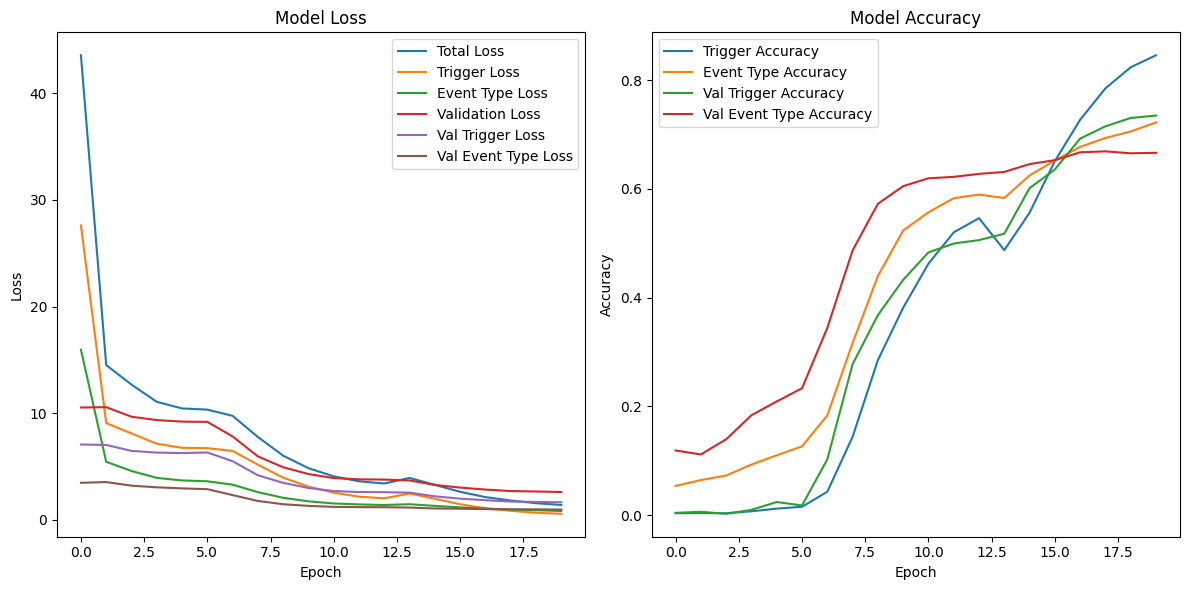

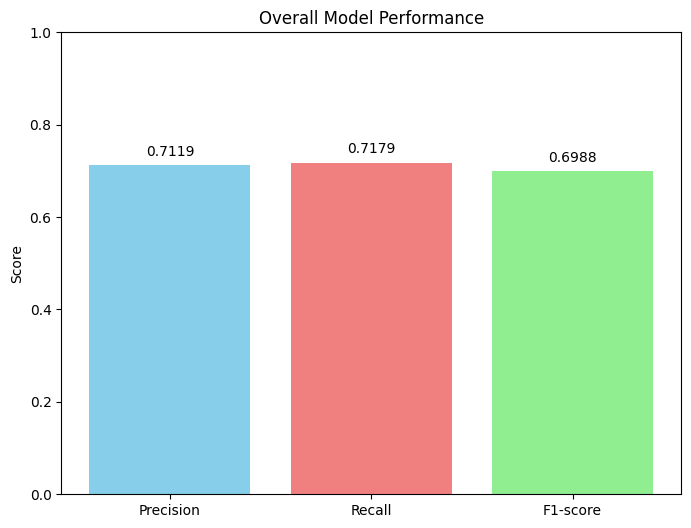

In [ ]:


import matplotlib.pyplot as plt

# Assuming 'history' is the training history object from model.fit()
# and overall_precision, overall_recall, overall_f1 are calculated as before

# Plot the training history for both tasks
plt.figure(figsize=(12, 6))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['trigger_output_loss'], label='Trigger Loss')
plt.plot(history.history['event_type_output_loss'], label='Event Type Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_trigger_output_loss'], label='Val Trigger Loss')
plt.plot(history.history['val_event_type_output_loss'], label='Val Event Type Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['trigger_output_accuracy'], label='Trigger Accuracy') # Changed to output-specific accuracy
plt.plot(history.history['event_type_output_accuracy'], label='Event Type Accuracy') # Changed to output-specific accuracy
plt.plot(history.history['val_trigger_output_accuracy'], label='Val Trigger Accuracy') # Changed to output-specific accuracy
plt.plot(history.history['val_event_type_output_accuracy'], label='Val Event Type Accuracy') # Changed to output-specific accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Bar plot for overall performance metrics
metrics = ['Precision', 'Recall', 'F1-score']
values = [overall_precision, overall_recall, overall_f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Overall Model Performance')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for better visualization
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')  # Add values on top of bars

plt.show()

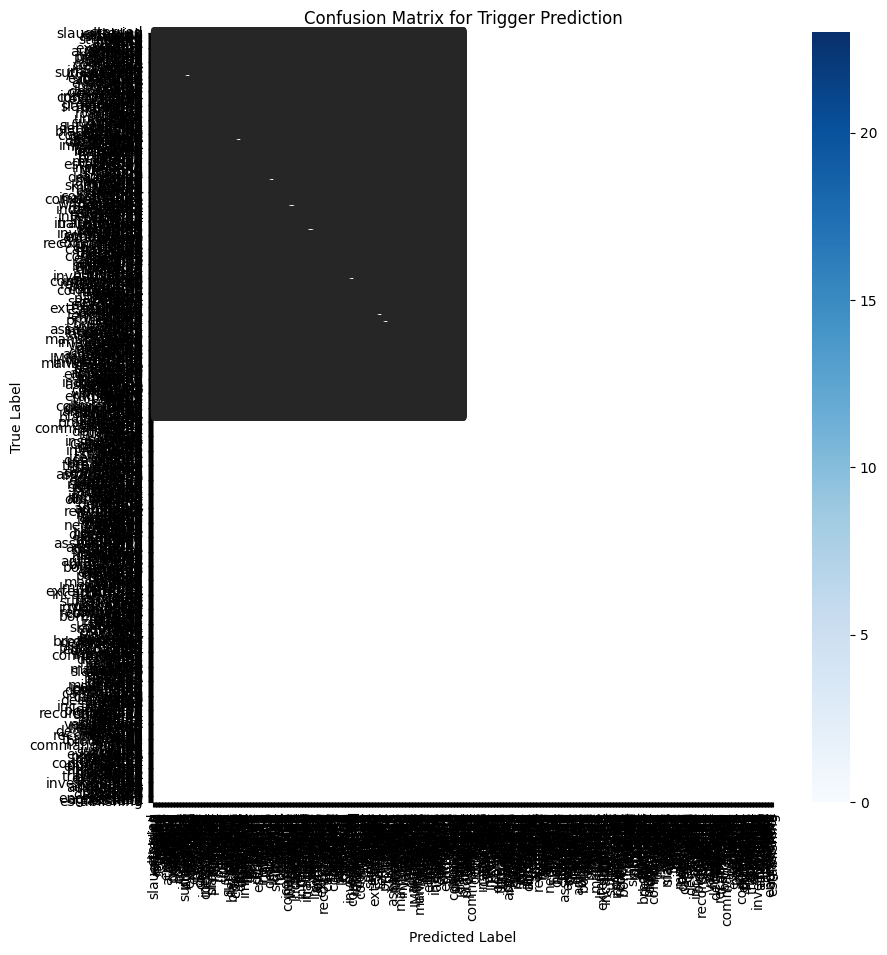

In [ ]:
import seaborn as sns

cm = confusion_matrix(trigger_true_labels, trigger_predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(event_trigger_mapping.keys()),
            yticklabels=list(event_trigger_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Trigger Prediction')
plt.show()

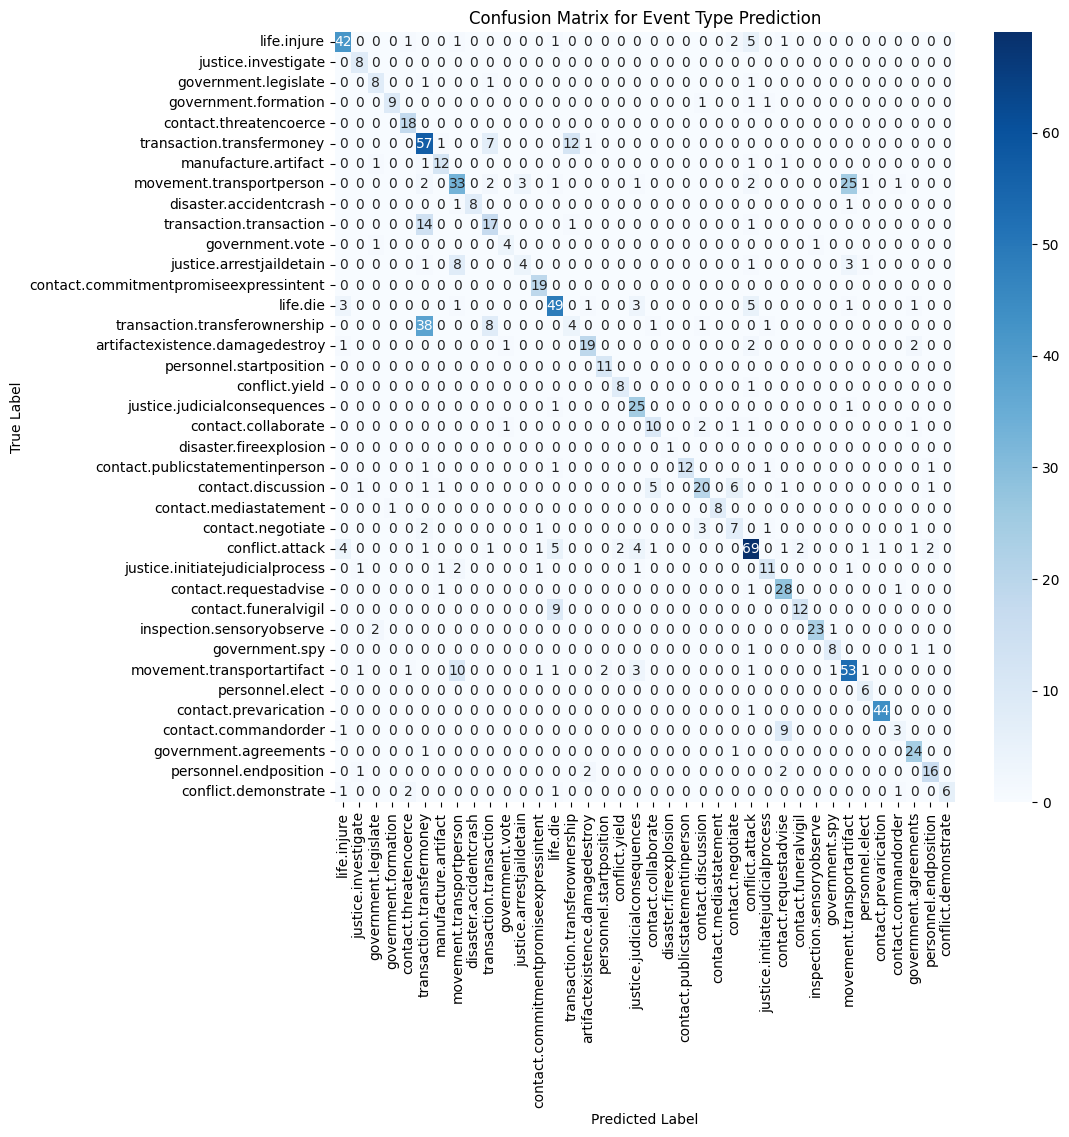

In [ ]:

cm_event_type = confusion_matrix(event_type_true_labels, event_type_predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_event_type, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(event_type_mapping.keys()),
            yticklabels=list(event_type_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Event Type Prediction')
plt.show()

In [ ]:
new_sentences = [
    "The court ruled in favor of the defendant in the recent trial.",
    "The children were evacuated safely from the building.",
    "The hospital receives 20-30 casualties from Israeli air strikes a day. Most are civilians, but no-one is turned away. “We take all patients, and all injured, and all martyrs who come,” he says. “We don't discriminate between them",
    "A Baltimore prosecutor accused a police detective of “sabotaging” investigations related to the death of Freddie Gray, accusing him of fabricating notes to suggest that the state’s medical examiner believed the manner of death was an accident rather than a homicide."
]

# Tokenize the new sentences, handling unknown tokens
new_encodings = tokenizer(
    new_sentences,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf',
    add_special_tokens=False  # Prevent adding special tokens outside the vocabulary
)

# Replace unknown token IDs with the 'unk_token_id'
new_encodings['input_ids'] = tf.where(
    new_encodings['input_ids'] >= tokenizer.vocab_size,
    tokenizer.unk_token_id,
    new_encodings['input_ids']
)

predictions = model.predict(dict(new_encodings))

# Get predicted labels for both tasks
trigger_predicted_labels = tf.argmax(predictions['trigger_output'], axis=1).numpy()
event_type_predicted_labels = tf.argmax(predictions['event_type_output'], axis=1).numpy()

# Map predicted labels back to original labels
predicted_triggers = [list(event_trigger_mapping.keys())[i] for i in trigger_predicted_labels]
predicted_event_types = [list(event_type_mapping.keys())[i] for i in event_type_predicted_labels]

for i, sentence in enumerate(new_sentences):
    print(f"Sentence: {sentence}")
    print(f"Predicted Trigger: {predicted_triggers[i]}")
    print(f"Predicted Event Type: {predicted_event_types[i]}")
    print("-" * 20)

1/1 [==============================] - 2s 2s/step
Sentence: The court ruled in favor of the defendant in the recent trial.
Predicted Trigger: trial
Predicted Event Type: justice.initiatejudicialprocess
--------------------
Sentence: The children were evacuated safely from the building.
Predicted Trigger: evacuated
Predicted Event Type: movement.transportperson
--------------------
Sentence: The hospital receives 20-30 casualties from Israeli air strikes a day. Most are civilians, but no-one is turned away. “We take all patients, and all injured, and all martyrs who come,” he says. “We don't discriminate between them
Predicted Trigger: injured
Predicted Event Type: life.injure
--------------------
Sentence: A Baltimore prosecutor accused a police detective of “sabotaging” investigations related to the death of Freddie Gray, accusing him of fabricating notes to suggest that the state’s medical examiner believed the manner of death was an accident rather than a homicide.
Predicted Trigger

In [ ]:
#************************dummy****************